In [ ]:
from seeq import spy
import pandas as pd
import re

## CSV File Structure
The csv file 'data_for_asset_tree_from_csv.csv' has 267842 rows where each row contains 13 values. The first row of the file is the header row which contains the signal names and the name of the timestamp column. The timestamp is the first value in every row. In summary, there is 1 timestamp column and 12 signal columns with the actual control loop data. The control loop data is scaled to zero mean and unit variance.
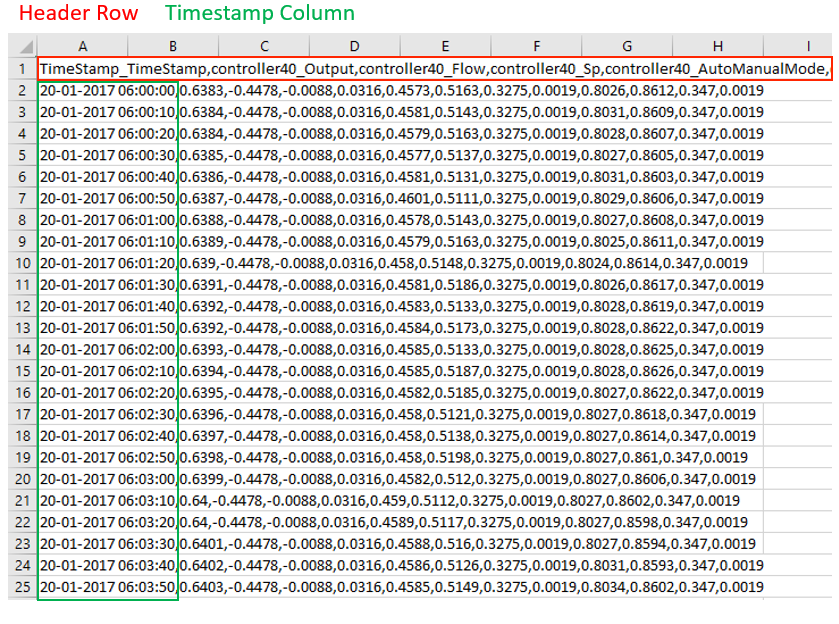

# Example Data
In the following, it will be demonstrated how an asset tree in the required format for the Constraint Detection Add-on can be built from data in a csv file. The Constraint Detection Add-on requires a layout where all assets on the bottom of the hierarchy are controllers. All signals linked to one controller must be either a 'Controller Output', a 'Setpoint', a 'Process Variable', a 'Mode' or a 'Manipulated Variable'. The correct naming is of high importance and other signal types won't be processed by the Add-on. For the demonstration, a dataset containing 12 signals from 3 controllers will be used. Every controller has a controller output, setpoint, process variable, and auto manual mode. The asset structure, which will be created, is shown below.
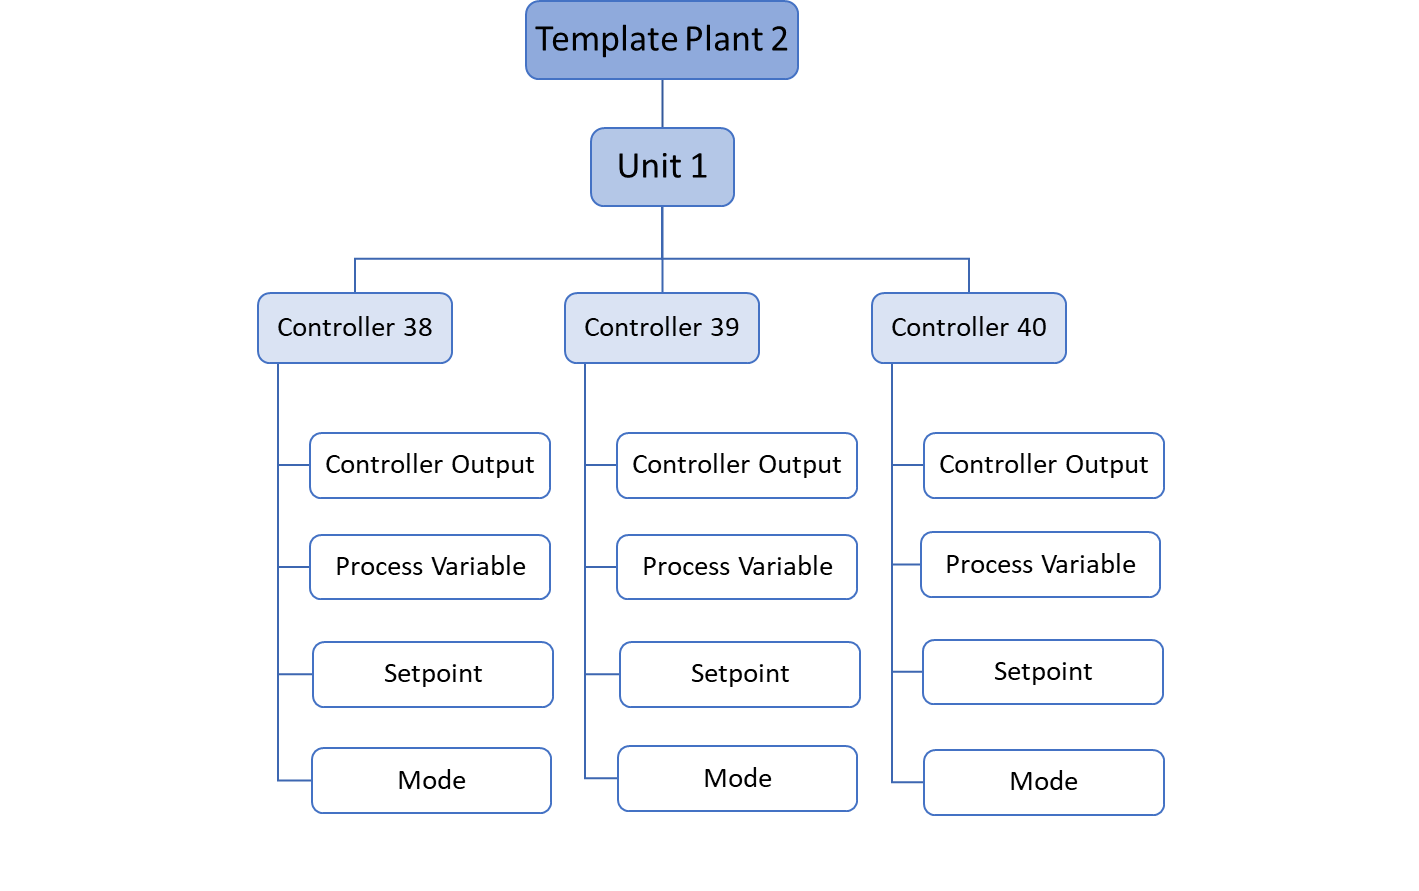

The data for the template asset tree is in a csv file. Therefore, the signals will imported to the Data Lab environment and then pushed to the workbench. The push_results dataframe shows the metadata of the pushed signals. If your data is already available in the workbench, you can use `spy.search` to get a metadata table of all signals you want to be in your asset tree.

In [ ]:
csv_file = pd.read_csv('data_for_asset_tree_from_csv.csv', parse_dates=['TimeStamp_TimeStamp'], index_col='TimeStamp_TimeStamp')
csv_file.head()

In [ ]:
push_results = spy.push(data=csv_file)
push_results

# Build Assets and Paths
To build an asset tree, a `Build Asset` and `Build Path` column have to be defined in the metadata. More information on this topic can be found in the `spy.assets` documentation (https://python-docs.seeq.com/user_guide/spy.assets/index.html). To use the Constraint Detection Add-on, the `Build Asset` column must specify a controller. In this example, the controllers are named using the word "Controller" followed by the individual controller number. Any other naming for the controller assets is accepted by the Add-on. For example, you could also use "FIC103" or "Reactor Temperature Control" as a name for the `Build Asset` column. The `Build Path` column points to you controller asset. It can be defined for every signal individually. Here, all controllers will be found under the same path. For example, one controller asset in this asset tree is 'Controller 40' and it lives under the path 'Template Plant >> Unit 1'.

In [ ]:
pd.set_option('mode.chained_assignment', None)

# generate an empty column for 'Build Asset'
push_results['Build Asset'] = ''

# Loop through every row in the metadata to get a formatted asset name
for i in range(push_results.shape[0]):
    # get the controller number using the re package
    controller_number = re.findall(r'\d+', push_results['Name'][i])
    # assign the the asset name to the 'Build Asset column'
    push_results['Build Asset'][i] = 'Controller ' + controller_number[0]

# generate the 'Build Path' column
push_results['Build Path'] = 'Template Plant 2 >> Unit 1'
push_results

# Asset Structure Class
`spy.assets` requires a class that defines the attributes which can be connected to an asset. Since all the assets in the asset structure should be controllers, the attributes will be control signals: Controller output, setpoint, auto manual mode, process variable and manipulated variable. The names of the attributes must not be changed, as this naming is required for the Constraint Detection Add-on. Instead, the returned signals need to be adapted so that they fit your data.

In [ ]:
from seeq.spy.assets import Asset, ItemGroup

class AssetStructureClass(Asset):
    
    @Asset.Attribute()
    def Controller_Output(self, metadata):
        df = metadata[metadata['Name'].str.endswith('_Output')]
        df = df.append(metadata[metadata['Name'].str.endswith('Speed')])
        return df
    
    @Asset.Attribute()
    def Setpoint(self, metadata):
        df = metadata[metadata['Name'].str.endswith('_Sp')]
        return df
    
    @Asset.Attribute()
    def Mode(self, metadata):
        df = metadata[metadata['Name'].str.endswith('_AutoManualMode')]
        return df
    
    @Asset.Attribute()
    def Process_Variable(self, metadata):
        df = metadata[metadata['Name'].str.endswith('_Flow')]
        df = df.append(metadata[metadata['Name'].str.endswith('_Level')])
        df = df.append(metadata[metadata['Name'].str.endswith('_AirFlow')])
        df = df.append(metadata[metadata['Name'].str.endswith('_Weightometer')])
        return df
    
    @Asset.Attribute()
    def Manipulated_Variable(self, metadata):
        df = metadata[metadata['Name'].str.endswith('_MV')]
        return df

# Metadata
Using the `spy.assets.build` function, the asset structure is generated from the class and the defined `Build Asset` and `Build Path` column. If there are attributes which cannot be matched to the metadata, the function will throw an error. Since the example data does not contain any manipulated variables, an error will show up for all 3 controllers saying that no matching metadata row was found for the Manipulated Variable attribute. In this case, this is not a problem because all other signals get matched successfully. The finished asset structure can be pushed to the workbench.

In [ ]:
metadata_asset_structure = spy.assets.build(AssetStructureClass, metadata = push_results)

In [ ]:
spy.push(metadata=metadata_asset_structure)